<a href="https://colab.research.google.com/github/deb-kit2/kaggle_comp/blob/master/plant_pathology/plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/plant_pathology_kaggle")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd

sam_sub = pd.read_csv('sample_submission.csv')
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [3]:
train_csv.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
def get_class(row): 
  if row['multiple_diseases'] == 1: 
    return 'multiple_diseases' 
  elif row['rust'] == 1: 
    return 'rust' 
  elif row['scab'] == 1: 
    return 'scab' 
  else: 
    return 'healthy' 
    
train_csv["label"] = train_csv.apply(get_class, axis=1) 
#train_csv.head()
temp = pd.factorize(train_csv["label"])
train_csv["label"] = temp[0]

train_csv.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,0
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,2
3,Train_3,0,0,1,0,3
4,Train_4,1,0,0,0,2


In [5]:
reference_map = {"scab" : 0, "multiple_diseases" : 1, "healthy" : 2, "rust" : 3}
y = train_csv["label"]

from keras.utils import to_categorical
y = to_categorical(y, 4)
y

Using TensorFlow backend.


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [6]:
test_csv.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [0]:
path = '/content/drive/My Drive/plant_pathology_kaggle/images/'
image_list = os.listdir(path)

train_images = train_csv["image_id"]
test_images = test_csv["image_id"]

train_images = np.asarray(train_images) + ".jpg"
test_images = np.asarray(test_images) + ".jpg"

In [8]:
train_images

array(['Train_0.jpg', 'Train_1.jpg', 'Train_2.jpg', ..., 'Train_1818.jpg',
       'Train_1819.jpg', 'Train_1820.jpg'], dtype=object)

In [9]:
image_height = 150
image_width = 150
channels = 3

import cv2
xtrain = np.zeros((len(y), image_height, image_width, channels))
xtest = np.zeros((len(y), image_height, image_width, channels))

for i in range(len(y)):
  imgtrain = train_images[i]
  imgtest = test_images[i]
  #path = '/content/drive/My Drive/plant_pathology_kaggle/images/' + img
  img = cv2.imread('/content/drive/My Drive/plant_pathology_kaggle/images/'+imgtrain)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (image_height, image_width))
  xtrain[i] = img
  img = cv2.imread('/content/drive/My Drive/plant_pathology_kaggle/images/'+imgtest)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (image_height, image_width))
  xtest[i] = img

"""
for i in range(len(y)):
  img = test_images[i]
  path = '/content/drive/My Drive/plant_pathology_kaggle/images/' + img
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (image_height, image_width))
  xtest[i] = img
"""

"\nfor i in range(len(y)):\n  img = test_images[i]\n  path = '/content/drive/My Drive/plant_pathology_kaggle/images/' + img\n  img = cv2.imread(path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  img = cv2.resize(img, (image_height, image_width))\n  xtest[i] = img\n"

In [10]:
print(xtrain.shape)
print(xtest.shape)

(1821, 150, 150, 3)
(1821, 150, 150, 3)


In [0]:
xtrain /= 255
xtest /= 255

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 267)

x_res, y_res = ros.fit_resample(xtrain.reshape((-1, image_height * image_width * channels)), y)
x_res = x_res.reshape((-1, image_height, image_width, channels))

x_res.shape, y_res.sum(axis=0)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2488, 150, 150, 3), array([622, 622, 622, 622]))

In [0]:
from sklearn.model_selection import train_test_split
xtrain, xcv, ytrain, ycv = train_test_split(x_res, y_res, test_size = 0.1, random_state = 267)

####Thats all basic pre-procesing.
Things to try next : 
  #iii. transfer learning
  #iv. without reshaping 

In [14]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras import models

model = models.Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "same", 
                 activation = "relu", input_shape = (image_height, image_width, channels)))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = "same", 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = "same", 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = "same", 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = "same", 
#                 activation ='relu'))
#model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = "same", 
#                 activation ='relu'))
#model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
#model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
from keras.optimizers import RMSprop
opti = RMSprop(lr = 1e-3)
model.compile(optimizer = opti, loss = "categorical_crossentropy", metrics = ["accuracy"])

from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, 
                                            verbose=1, factor=0.5, min_lr = 1e-10)

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = "/content/res_aug.h5", 
                             save_best_only = True, monitor = "val_loss",
                             verbose = 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 45, width_shift_range = 0.2, height_shift_range = 0.2,
                             zoom_range = 0.2, horizontal_flip = True, vertical_flip = True)

datagen.fit(xtrain)

train_size = len(ytrain)

In [17]:
history = model.fit_generator(datagen.flow(x = xtrain, y = ytrain, batch_size = 32), 
                    epochs = 100, steps_per_epoch = train_size//32, 
                    validation_data = (xcv, ycv), 
                    callbacks = [learning_rate_reduction, checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





69/69 [==============================] - 67s 971ms/step - loss: 1.6090 - acc: 0.2574 - val_loss: 1.3847 - val_acc: 0.2530

Epoch 00001: val_loss improved from inf to 1.38468, saving model to /content/res_aug.h5
Epoch 2/100
69/69 [==============================] - 66s 957ms/step - loss: 1.3949 - acc: 0.2628 - val_loss: 1.3810 - val_acc: 0.3173

Epoch 00002: val_loss improved from 1.38468 to 1.38096, saving model to /content/res_aug.h5
Epoch 3/100
69/69 [==============================] - 66s 956ms/step - loss: 1.3887 - acc: 0.2524 - val_loss: 1.3915 - val_acc: 0.2570

Epoch 00003: val_loss did not improve from 1.38096
Epoch 4/100
69/69 [==============================] - 66s 950ms/step - loss: 1.3989 - acc: 0.2899 - val_loss: 1.3618 - val_acc: 0.3333

Epoch 00004: val_loss improved from 1.38096 to 1.36180, saving model to /content/res_aug.h5
Epoch 5/100
69/69 [================

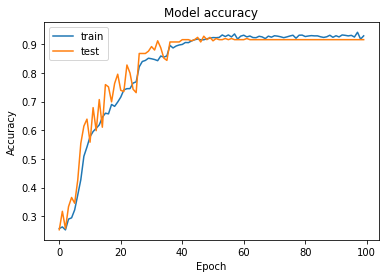

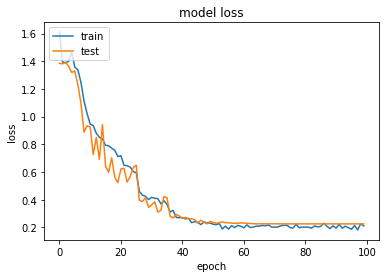

In [18]:
import matplotlib.pyplot as plt
#plt.subplots(2,1)
#plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Model accuracy")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [0]:
from keras.models import load_model
net = load_model("/content/res_aug.h5")

predictions = net.predict(xtest)
temp = predictions
predictions = np.argmax(predictions, axis = 1)

In [20]:
sam_sub["healthy"].values[:] = 0
sam_sub["multiple_diseases"].values[:] = 0
sam_sub["rust"].values[:] = 0
sam_sub["scab"].values[:] = 0

for i in range(len(predictions)):
  if predictions[i] == 0:
    sam_sub["scab"].values[i] = 1
  elif predictions[i] == 1:
    sam_sub["multiple_diseases"].values[i] = 1
  elif predictions[i] == 2:
    sam_sub["healthy"].values[i] = 1
  elif predictions[i] == 3:
    sam_sub["rust"].values[i] = 1

sam_sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.0,0.0,1.0,0.0
1,Test_1,0.0,0.0,1.0,0.0
2,Test_2,0.0,0.0,0.0,1.0
3,Test_3,1.0,0.0,0.0,0.0
4,Test_4,0.0,0.0,1.0,0.0


In [0]:
sam_sub.to_csv("/content/res_aug.csv", index = False)